# Import Required Libraries

In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform  # Import randint and uniform

import os
import json
import time,joblib


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder

from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score,roc_curve,precision_score, auc,ConfusionMatrixDisplay,classification_report,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Load Processed Dataset

In [3]:
mined_df = pd.read_csv("processed_mined_df.csv")

In [4]:
print("mined transaction shape", mined_df.shape)

mined transaction shape (500, 14)


In [5]:
print("mined transaction features",  sorted(mined_df.columns.to_list()))

mined transaction features ['blockNumber', 'from', 'gasLimit', 'gasPrice', 'hash', 'input', 'maxFeePerGas', 'maxPriorityFeePerGas', 'nonce', 'r', 's', 'to', 'v', 'value']


In [6]:
print("mined transaction features", mined_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   hash                  500 non-null    object
 1   blockNumber           500 non-null    int64 
 2   from                  500 non-null    object
 3   to                    500 non-null    object
 4   nonce                 500 non-null    int64 
 5   input                 500 non-null    object
 6   r                     500 non-null    object
 7   s                     500 non-null    object
 8   v                     500 non-null    int64 
 9   gasPrice              500 non-null    int64 
 10  maxPriorityFeePerGas  500 non-null    int64 
 11  maxFeePerGas          500 non-null    int64 
 12  gasLimit              500 non-null    int64 
 13  value                 500 non-null    object
dtypes: int64(7), object(7)
memory usage: 54.8+ KB
mined transaction features None


In [7]:
print("mined transaction non-numeric features", sorted(mined_df.select_dtypes(exclude=['number']).columns.tolist()))

mined transaction non-numeric features ['from', 'hash', 'input', 'r', 's', 'to', 'value']


# Feature Engineering



In [8]:
def transaction_preprocessing(df):
    # # Encode addresses and function signatures
    # # Create a single list of unique addresses from both 'from' and 'to' columns
    # all_addresses = pd.concat([df['from'], df['to']]).unique()

    # label_encoder = LabelEncoder()
    # # Fit the LabelEncoder on all unique addresses
    # label_encoder.fit(all_addresses)

    # df['from_id'] = label_encoder.fit_transform(df['from'])
    # df['to_id'] = label_encoder.transform(df['to'])

    # # Function Signature Extraction:
    # df['function_signature'] = df['input'].str.strip().replace('0x','0').apply(lambda x: x[:16] if len(x) >= 10 else x)
    # df['function_signature'] = label_encoder.fit_transform(df['function_signature'])


    # Function Signature Extraction:
    df['function_signature'] = df['input'].str.strip().replace('0x','0').apply(lambda x: x[:16] if len(x) >= 10 else x)
    df['function_signature'] = df['function_signature'].apply(lambda x: int(x, 16))

    # Contract Interaction Flag:
    df['is_contract_interaction'] = df['input'].apply(lambda x: 1 if x != '0x' else 0)

    # Input Length
    df['input_length'] = df['input'].apply(len)

    #Limit the length of the hex string to avoid overflow
    df['input'] = df['input'].str.strip().replace('0x','0').apply(lambda x: x[:16] if len(x) >= 18 else x)
    df['input'] = df['input'].apply(lambda x: int(x, 16))

    # Convert the string to a numeric type
    df['from'] = df['from'].astype(float)
    df['to'] = df['to'].astype(float)
    df['hash'] = df['hash'].astype(float)
    df['r'] = df['r'].astype(float)
    df['s'] = df['s'].astype(float)
    df['value'] = df['value'].astype(float)

    # drop duplicated
    df = df.drop_duplicates()

    return df




In [9]:
mined_df = transaction_preprocessing(mined_df)

In [10]:
print("mined transaction features", mined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hash                     500 non-null    float64
 1   blockNumber              500 non-null    int64  
 2   from                     500 non-null    float64
 3   to                       500 non-null    float64
 4   nonce                    500 non-null    int64  
 5   input                    500 non-null    int64  
 6   r                        500 non-null    float64
 7   s                        500 non-null    float64
 8   v                        500 non-null    int64  
 9   gasPrice                 500 non-null    int64  
 10  maxPriorityFeePerGas     500 non-null    int64  
 11  maxFeePerGas             500 non-null    int64  
 12  gasLimit                 500 non-null    int64  
 13  value                    500 non-null    float64
 14  function_signature       5

hash                       0.025869
blockNumber                1.000000
from                       0.029126
to                         0.026580
nonce                     -0.046014
input                     -0.068316
r                         -0.038978
s                          0.065600
v                         -0.058963
gasPrice                  -0.101897
maxPriorityFeePerGas      -0.067378
maxFeePerGas              -0.002429
gasLimit                  -0.033662
value                     -0.029374
function_signature        -0.068316
is_contract_interaction    0.016418
input_length               0.100494
Name: blockNumber, dtype: float64


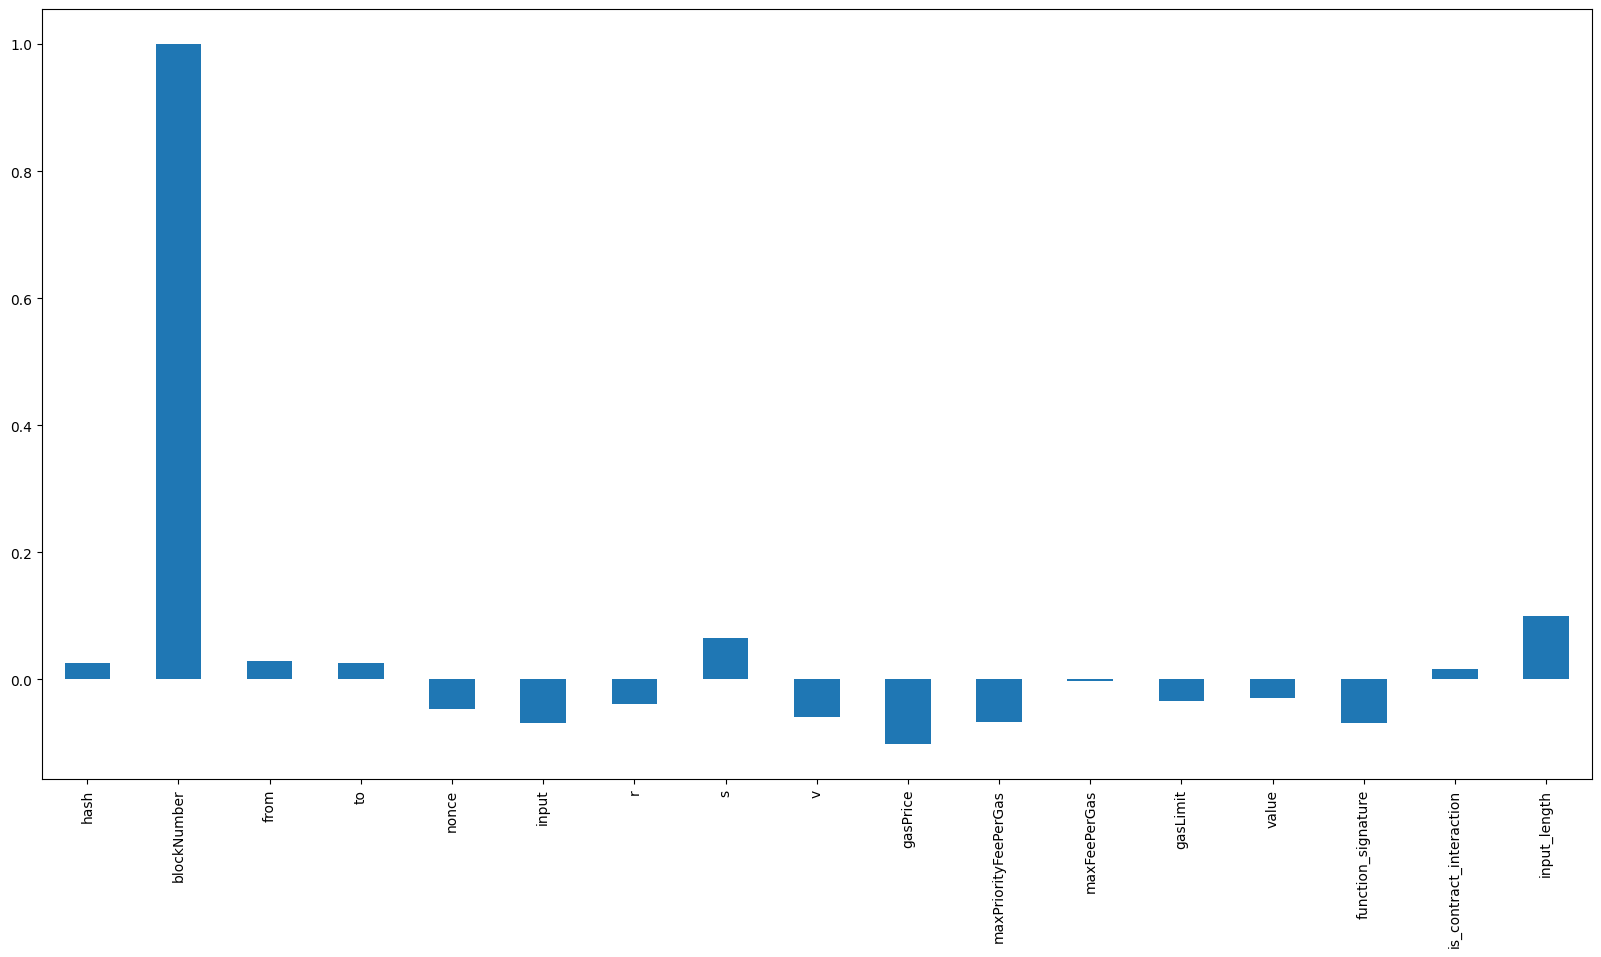

In [11]:
# Finding out the correlation between the features
correlation_matrix = mined_df.corr()
correlation_matrix['blockNumber'].plot(kind='bar', figsize=(20,10))
print(correlation_matrix['blockNumber'])

<Axes: xlabel='blockNumber'>

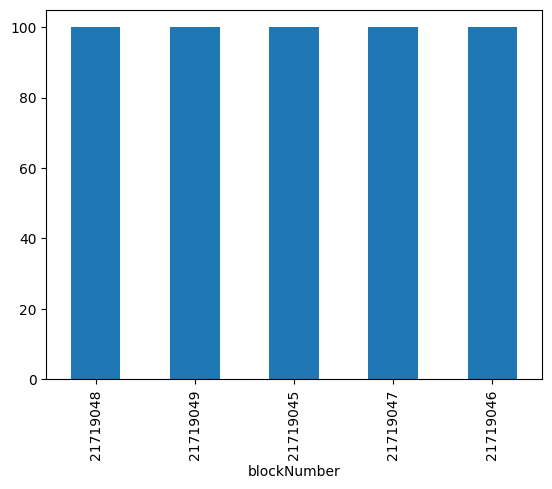

In [12]:
mined_df['blockNumber'].value_counts().plot(kind='bar')

In [13]:
# Label Encoding for target
label_encoder = LabelEncoder()
mined_df['blockNumber'] = label_encoder.fit_transform(mined_df['blockNumber'])

In [14]:
def PerformanceMetric(Model,X_train,X_test,y_train,y_test,y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    # Changed 'binary' to 'weighted' for precision, recall, and f1-score calculations
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    f1 = f1_score(y_test,y_pred, average='weighted')

    print('Testing Accuracy:', round(accuracy*100,2),'%')
    print('Testing Precision:', round(precision*100,2),'%')
    print('Testing Recall:', round(recall*100,2),'%')
    print('Testing F1 Score:', round(f1*100,2),'%')

    # Handle multiclass classification for ROC curve and AUC
    if len(np.unique(y_test)) > 2:  # Check if multiclass
        # Convert to binary classification for each class
        from sklearn.preprocessing import label_binarize
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
        y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_test_bin.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and AUC
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Plot micro-average ROC curve
        plt.figure(figsize=(15,5))
        plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
                                               ''.format(roc_auc["micro"]))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    #confusion metrix
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(15,5))
    plt.title("Confusion Matrix")
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    plt.show()

    return accuracy,precision,recall,f1

# Model Building

In [15]:
PerformanceResults = []

In [16]:
# Define dependent and independent features
X = mined_df.drop("blockNumber", axis=1)
y = mined_df["blockNumber"]

In [17]:
X.columns

Index(['hash', 'from', 'to', 'nonce', 'input', 'r', 's', 'v', 'gasPrice',
       'maxPriorityFeePerGas', 'maxFeePerGas', 'gasLimit', 'value',
       'function_signature', 'is_contract_interaction', 'input_length'],
      dtype='object')

In [18]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Print the shapes of the resulting datasets
print("Shapes of training and testing sets:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of training and testing sets:
X_train: (400, 16)
X_test: (100, 16)
y_train: (400,)
y_test: (100,)


In [20]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
# Remove rows with any missing values in X and corresponding rows in y
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Align y_train with the dropped rows in X_train

X_test = X_test.dropna()
y_test = y_test[X_test.index]  # Align y_test with the dropped rows in X_test

# Now proceed with scaling and model training...

## Random Forest

In [22]:
# grid searching key hyperparameters for RandomForestClassifier
Start_time= time.time()

# define models and parameters
RF = RandomForestClassifier()
n_estimators = [5,10,15]
max_features = ['sqrt', 'log2']

# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

RF_random_search = GridSearchCV(estimator=RF, param_grid=grid, cv=5, scoring='roc_auc')
RF_random_result = RF_random_search.fit(X_train_scaled, y_train)

# summarize results
print("Best: %f using %s" % (RF_random_result.best_score_, RF_random_result.best_params_))

# check recall on test set
y_val_predict = RF_random_result.predict(X_test_scaled)

Best: nan using {'max_features': 'sqrt', 'n_estimators': 5}


Testing Accuracy: 36.0 %
Testing Precision: 40.2 %
Testing Recall: 36.0 %
Testing F1 Score: 37.33 %


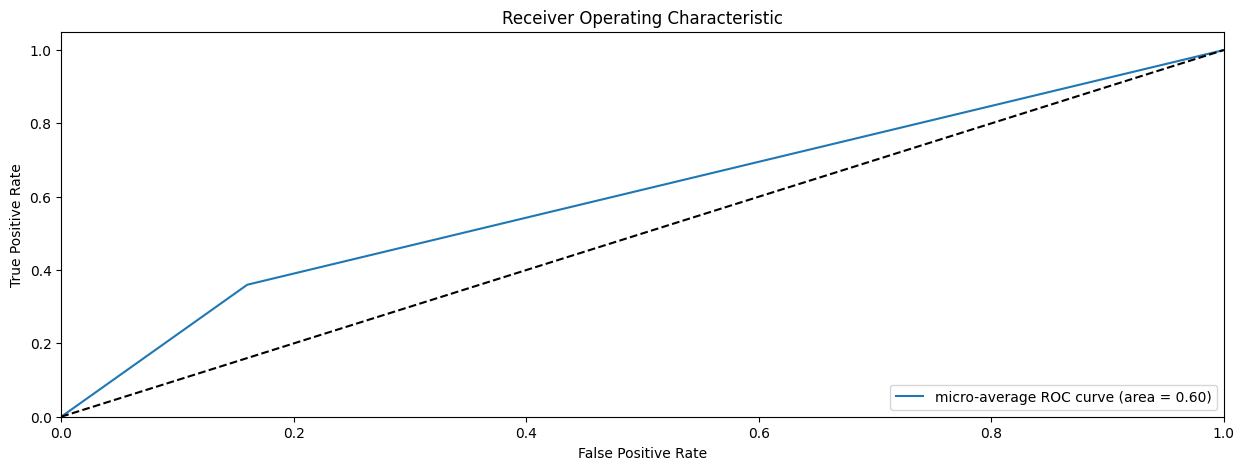

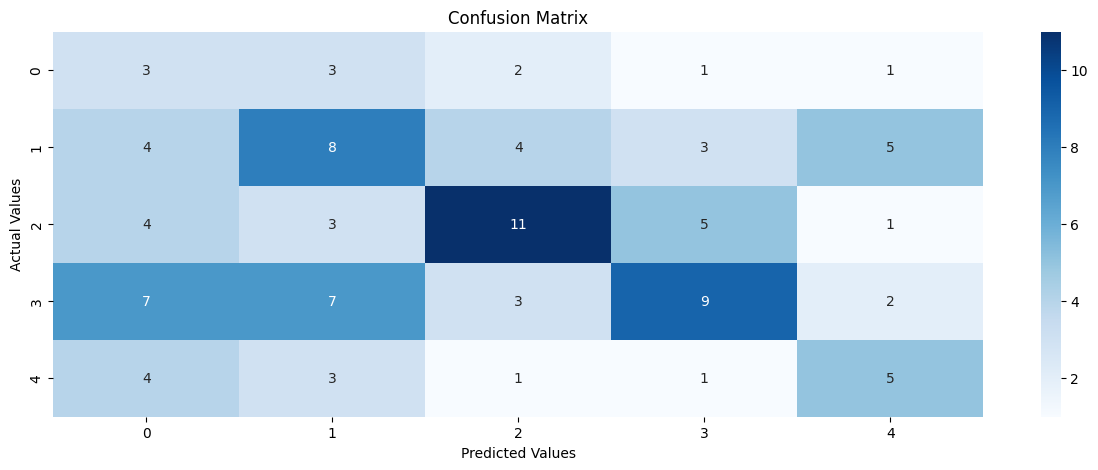

Model Train Time Taken: 3.583704948425293


In [23]:
accuracy,precision,recall,f1 = PerformanceMetric(RF_random_search,X_train,X_test,y_train,y_test,y_val_predict)
print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['Random Forest Classifier',accuracy,precision,recall,f1,time.time()-Start_time])

## XGBoost

In [24]:
#grid searching key hyperparameters for GradientBoostingClassifier
Start_time = time.time()

# define models and parameters
XGB = xgb.XGBClassifier()

# A parameter grid for XGBoost
grid = {"learning_rate": (0.01, 0.1),
        'min_child_weight': [1, 5, 10],
        'gamma': [ 0.0, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [ 0.3, 0.4],
        'max_depth': [3, 4, 5]
        }

# define grid search
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
XGB_random_search = GridSearchCV(estimator=XGB, param_grid=grid, cv=5, scoring='roc_auc')

Testing Accuracy: 36.0 %
Testing Precision: 40.2 %
Testing Recall: 36.0 %
Testing F1 Score: 37.33 %


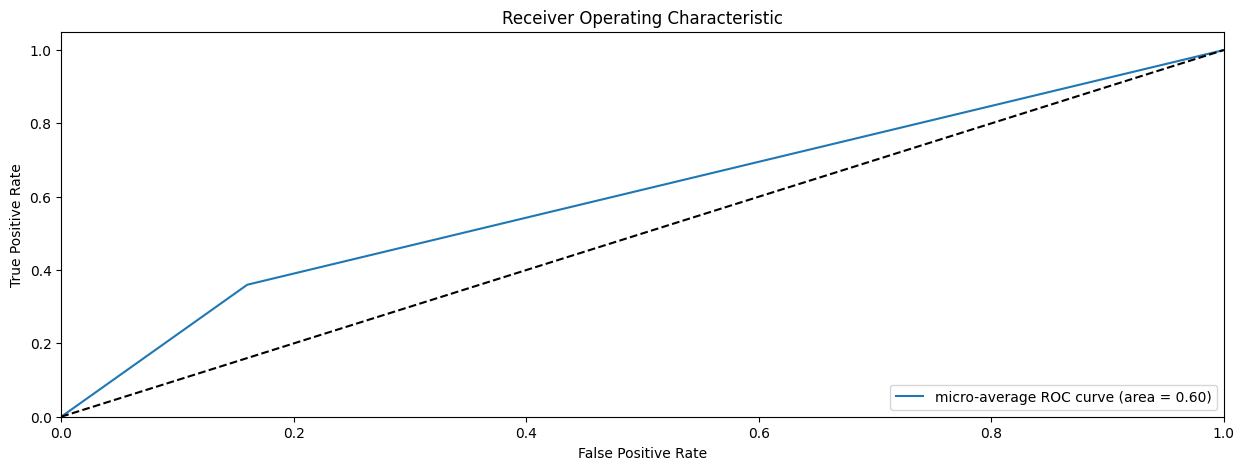

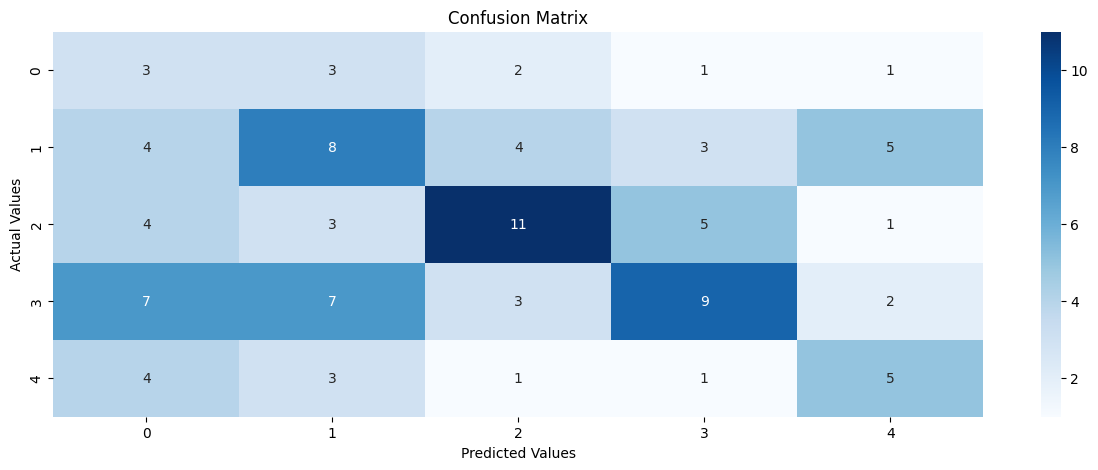

Model Train Time Taken: 1.0562498569488525


In [25]:
accuracy,precision,recall,f1 = PerformanceMetric(XGB_random_search,X_train,X_test,y_train,y_test,y_val_predict)
print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['XGBoost Classifier',accuracy,precision,recall,f1,time.time()-Start_time])

# CatBoostingClassifier

In [26]:
#grid searching key hyperparameters for CatBoostingClassifier
Start_time = time.time()

#Instantiate CatBoostClassifier
catboost_classifier = CatBoostClassifier()

#create the grid
grid = {'max_depth': [3,4,5],'n_estimators':[100, 200, 300]}

# define grid search
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
CB_random_search = GridSearchCV(estimator=catboost_classifier, param_grid=grid, cv=5, scoring='roc_auc')
CB_random_result = CB_random_search.fit(X_train_scaled, y_train)

# summarize results
print("Best: %f using %s" % (CB_random_result.best_score_, CB_random_result.best_params_))

# check recall on test set
y_val_predict = CB_random_result.predict(X_test_scaled)

Streaming output truncated to the last 5000 lines.
23:	learn: 1.0529309	total: 180ms	remaining: 1.32s
24:	learn: 1.0315530	total: 189ms	remaining: 1.32s
25:	learn: 0.9917974	total: 195ms	remaining: 1.3s
26:	learn: 0.9845501	total: 200ms	remaining: 1.28s
27:	learn: 0.9348801	total: 207ms	remaining: 1.27s
28:	learn: 0.9277500	total: 214ms	remaining: 1.26s
29:	learn: 0.9228030	total: 222ms	remaining: 1.26s
30:	learn: 0.9116675	total: 226ms	remaining: 1.23s
31:	learn: 0.9034406	total: 234ms	remaining: 1.23s
32:	learn: 0.8936341	total: 241ms	remaining: 1.22s
33:	learn: 0.8802867	total: 246ms	remaining: 1.2s
34:	learn: 0.8598928	total: 254ms	remaining: 1.2s
35:	learn: 0.8512061	total: 261ms	remaining: 1.19s
36:	learn: 0.8468939	total: 268ms	remaining: 1.18s
37:	learn: 0.8136017	total: 275ms	remaining: 1.17s
38:	learn: 0.8073423	total: 284ms	remaining: 1.17s
39:	learn: 0.7783897	total: 289ms	remaining: 1.16s
40:	learn: 0.7622340	total: 297ms	remaining: 1.15s
41:	learn: 0.7473748	total: 303ms	

Testing Accuracy: 60.0 %
Testing Precision: 59.02 %
Testing Recall: 60.0 %
Testing F1 Score: 58.88 %


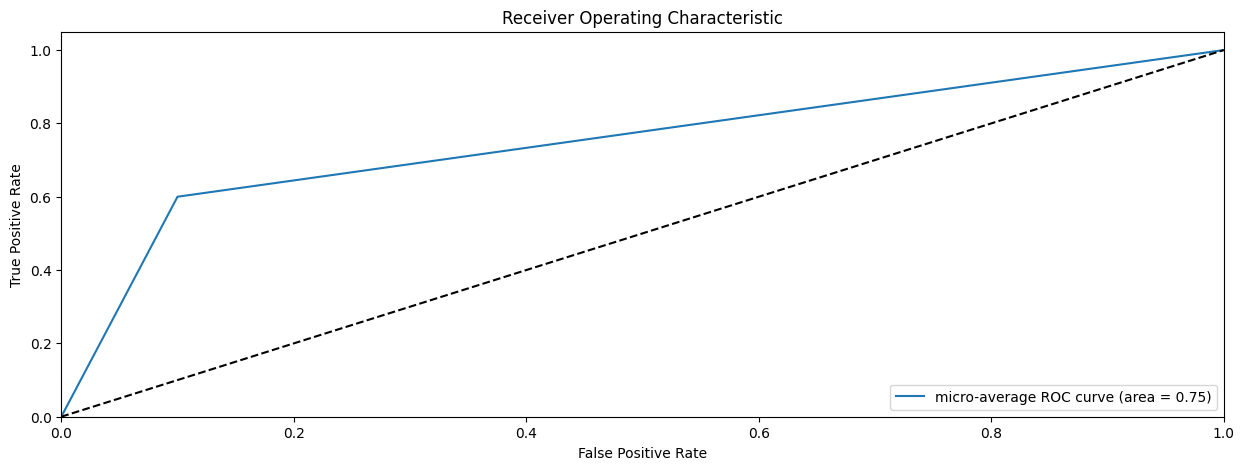

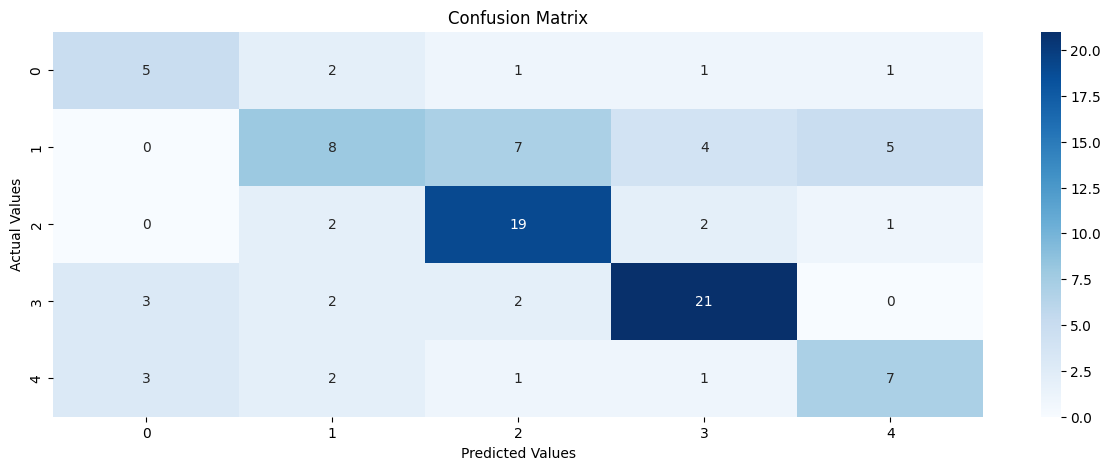

Model Train Time Taken: 60.23949670791626


In [27]:
accuracy,precision,recall,f1 = PerformanceMetric(CB_random_search,X_train,X_test,y_train,y_test,y_val_predict)
print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['CatBoost Classifier',accuracy,precision,recall,f1,time.time()-Start_time])

# Light Graident BoostingClassifier

In [28]:
#grid searching key hyperparameters for Light Graident BoostingClassifier
Start_time = time.time()

# define models and parameters
lgb_classifier = lgb.LGBMClassifier()

# A parameter grid for Light GBBoost
grid = {"learning_rate": (0.001, 0.01, 0.1),
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [ 0.3, 0.4],
        'max_depth': [3, 4, 5]
        }

# define grid search
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
LGB_random_search = RandomizedSearchCV(estimator=lgb_classifier, param_distributions=grid, n_iter=3, cv=5, scoring='roc_auc', random_state=42)
LGB_random_result = LGB_random_search.fit(X_train_scaled, y_train)

# summarize results
print("Best: %f using %s" % (LGB_random_result.best_score_, LGB_random_result.best_params_))

# check recall on test set
y_val_predict = LGB_random_result.predict(X_test_scaled)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Testing Accuracy: 64.0 %
Testing Precision: 63.29 %
Testing Recall: 64.0 %
Testing F1 Score: 62.86 %


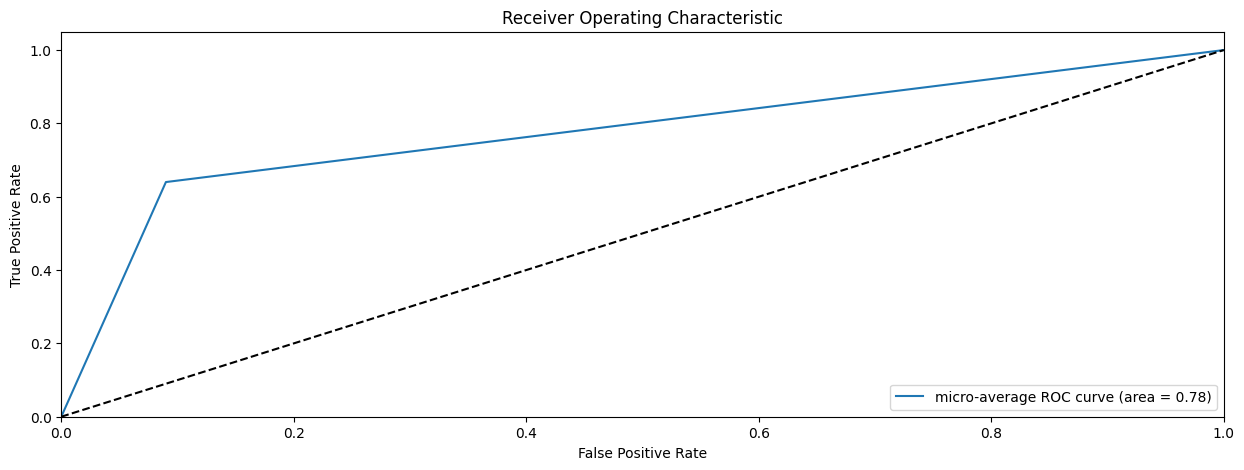

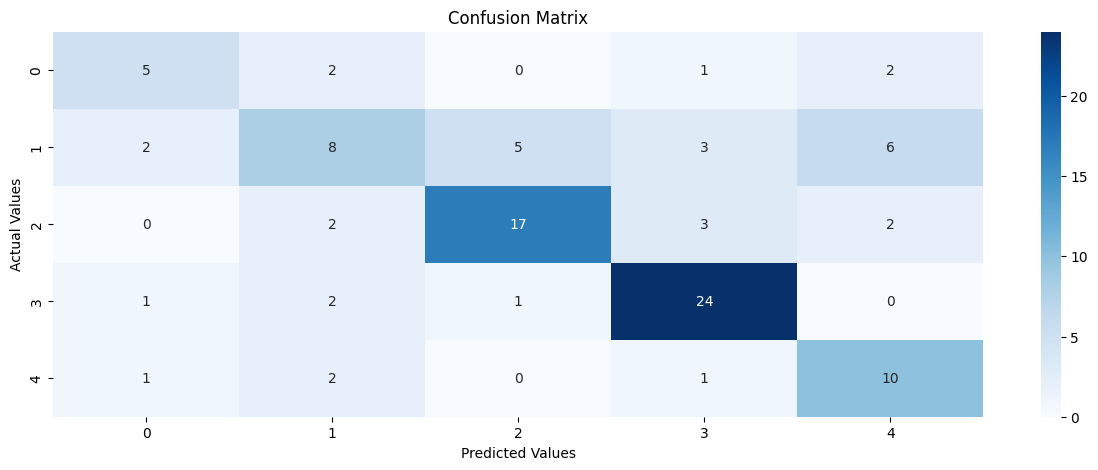

Model Train Time Taken: 5.614312410354614


In [29]:
accuracy,precision,recall,f1 = PerformanceMetric(LGB_random_search,X_train,X_test,y_train,y_test,y_val_predict)
print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['Light GBoost Classifier',accuracy,precision,recall,f1,time.time()-Start_time])

# LSTM

In [30]:
Start_time = time.time()

In [31]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


In [32]:
# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [33]:
# LSTM Model with Dropout and L2 Regularization
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.unsqueeze(1)  # Adding sequence dimension
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Apply dropout after LSTM
        out = self.fc(out)
        return out


In [34]:
# Hyperparameter tuning
param_distributions = {
    'hidden_dim': randint(64, 256),
    'num_layers': randint(1, 4),
    'dropout_rate': uniform(0.1, 0.5),
    'learning_rate': uniform(1e-4, 1e-2),
    'l2_penalty': uniform(1e-5, 1e-3)
}

best_params = None
best_f1 = 0
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

for _ in range(20):  # Random search iterations
    params = {k: v.rvs() for k, v in param_distributions.items()}
    model = LSTMClassifier(input_dim, int(params['hidden_dim']), output_dim, int(params['num_layers']), params['dropout_rate'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['l2_penalty'])

    # Training loop
    for epoch in range(50):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        y_pred_classes = torch.argmax(y_pred, dim=1)

    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    if f1 > best_f1:
        best_f1 = f1
        best_params = params

print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'hidden_dim': 100, 'num_layers': 2, 'dropout_rate': 0.25776032771554147, 'learning_rate': 0.009914469558257505, 'l2_penalty': 0.0007030389341483313}


In [35]:
# Final model with best hyperparameters
model = LSTMClassifier(input_dim, int(best_params['hidden_dim']), output_dim, int(best_params['num_layers']), best_params['dropout_rate'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['l2_penalty'])


In [36]:
# Final training loop
for epoch in range(50):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()


In [37]:
# Final evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, dim=1)

In [38]:
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['LSTM',accuracy,precision,recall,f1,time.time()-Start_time])

print(f"Final LSTM Model Performance:\nAccuracy: {accuracy:.2f}\nPrecision: {precision:.3f}\nRecall: {recall:.2f}\nF1 Score: {f1}")

Model Train Time Taken: 135.2912049293518
Final LSTM Model Performance:
Accuracy: 0.22
Precision: 0.266
Recall: 0.22
F1 Score: 0.22806155437734385


# Graph Convolutional Networks

In [39]:
Start_time = time.time()

In [40]:
!pip install torch_geometric
!pip install scikit-optimize


In [41]:
from torch_geometric.data import Data as GeoData
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from skopt import BayesSearchCV
from skopt.space import Real, Integer


In [42]:
# If 'from' and 'to' are not integers, convert them using a mapping
unique_nodes = pd.concat([X_train['from'], X_train['to']]).unique()
node_to_index = {node: index for index, node in enumerate(unique_nodes)}

# Map 'from' and 'to' to their corresponding indices
from_indices = X_train['from'].map(node_to_index).values
to_indices = X_train['to'].map(node_to_index).values

# Now create the edge_index tensor
edge_index = torch.tensor([from_indices, to_indices], dtype=torch.long)

# Ensure edge indices are within the range of node features
edge_index = edge_index.clamp(0, X_train.shape[0] - 1)  # Clamp to the valid range

node_features = torch.tensor(X_train_scaled, dtype=torch.float)
data = GeoData(x=node_features, edge_index=edge_index)

In [43]:
# GCN Model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [44]:
!pip install skorch

In [45]:
# Skorch Wrapper
from skorch import NeuralNetClassifier

class GCN_skorch(NeuralNetClassifier):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate, **kwargs):
        # Remove module__input_dim, module__hidden_dim, module__output_dim, module__dropout_rate from kwargs
        # These are already defined as parameters and will be passed to the module via get_params
        kwargs.pop('module__input_dim', None)  # Remove if exists in kwargs
        kwargs.pop('module__hidden_dim', None)
        kwargs.pop('module__output_dim', None)
        kwargs.pop('module__dropout_rate', None)

        # Pass GCN as the module using the 'module' keyword argument
        super().__init__(
            module=GCN,  # Pass GCN here
            module__input_dim=input_dim,
            module__hidden_dim=hidden_dim,
            module__output_dim=output_dim,
            module__dropout_rate=dropout_rate,
            **kwargs  # Now pass the modified kwargs
        )

    # Add this method to pass parameters to the clone method
    def __sklearn_clone__(self):
        return type(self)(
            input_dim=self.module__input_dim,
            hidden_dim=self.module__hidden_dim,
            output_dim=self.module__output_dim,
            dropout_rate=self.module__dropout_rate,
            **self.get_params(deep=False)  # Get and pass other params
        )

In [46]:
# Manual Hyperparameters
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))
hidden_dim = 128  # Set manually
dropout_rate = 0.1  # Set manually
learning_rate = 0.01  # Set manually
weight_decay = 1e-4  # Set manually


In [47]:
# Model Initialization with manual parameters
model = GCN(
    input_dim=X_train.shape[1],
    hidden_dim=hidden_dim,
    output_dim=len(np.unique(y_train)),
    dropout_rate=dropout_rate
)

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Early Stopping Parameters
patience = 5
best_loss = np.inf
patience_counter = 0

# Training the Model
number_of_iteration =1000
for epoch in range(number_of_iteration):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, torch.tensor(y_train.values, dtype=torch.long))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{number_of_iteration}], Loss: {loss.item():.4f}')

    # Early Stopping Check
    if loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))


Epoch [10/1000], Loss: 1.4277
Epoch [20/1000], Loss: 1.3109
Epoch [30/1000], Loss: 1.1914
Epoch [40/1000], Loss: 1.1209
Epoch [50/1000], Loss: 1.0332
Epoch [60/1000], Loss: 1.0218
Epoch [70/1000], Loss: 0.9206
Early stopping triggered


<All keys matched successfully>

In [49]:
# Evaluation
model.eval()
with torch.no_grad():
    output = model(data)
    y_pred_classes = torch.argmax(output, dim=1)

In [50]:
accuracy = accuracy_score(y_train, y_pred_classes)
precision = precision_score(y_train, y_pred_classes, average='weighted')
recall = recall_score(y_train, y_pred_classes, average='weighted')
f1 = f1_score(y_train, y_pred_classes, average='weighted')

print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['GCN',accuracy,precision,recall,f1,time.time()-Start_time])

print(f"Final GCN Model Performance:\nAccuracy: {accuracy:.2f}\nPrecision: {precision:.3f}\nRecall: {recall:.2f}\nF1 Score: {f1}")


Model Train Time Taken: 12.486562490463257
Final GCN Model Performance:
Accuracy: 0.70
Precision: 0.707
Recall: 0.70
F1 Score: 0.700615074374625


# Model Evaluation

In [51]:
Report = pd.DataFrame(PerformanceResults,columns=['Model','Accuracy','Precision','Recall','F1Score','TrainingTime'])
Report

,Model,Accuracy,Precision,Recall,F1Score,TrainingTime
0,Random Forest Classifier,0.36,0.401982,0.36,0.373317,3.584011
1,XGBoost Classifier,0.36,0.401982,0.36,0.373317,1.057888
2,CatBoost Classifier,0.60,0.590213,0.60,0.588824,60.239661
3,Light GBoost Classifier,0.64,0.632947,0.64,0.628602,5.614489
4,LSTM,0.22,0.265947,0.22,0.228062,135.291410
5,GCN,0.70,0.706820,0.70,0.700615,12.489684


# Model Assessment

In [52]:
# Save the trained model
torch.save(model.state_dict(), 'final_gcn_model.pth')

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')



['label_encoder.pkl']